# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

# Load Data

In [5]:
df_train = pd.read_csv('./data/df_train_prepared.csv')

df_train = df_train.rename(columns={'mcc_lable': 'mcc_label'})
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,std15,std16,std17,std18,std19,std20,std21,ttf,bnc_label,mcc_label
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [6]:
df_test = pd.read_csv('./data/df_test_prepared.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,std15,std16,std17,std18,std19,std20,std21,ttf,bnc_label,mcc_label
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


In [7]:
# original features
features_orignal = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_all = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                's15', 's16', 's17', 's18', 's19', 's20', 's21', 'avg1', 'avg2', 'avg3','avg4', 'avg5', 'avg6', 'avg7', 'avg8', 'avg9', 'avg10',
                'avg11','avg12', 'avg13', 'avg14', 'avg15', 'avg16', 'avg17', 'avg18', 'avg19','avg20', 'avg21', 'std1', 'std2', 'std3', 'std4',
                'std5', 'std6','std7', 'std8', 'std9', 'std10', 'std11', 'std12', 'std13', 'std14','std15', 'std16', 'std17', 'std18', 'std19', 'std20', 'std21']


# features with low or no correlation with regression label
features_lowcor = ['setting3', 's1', 's10', 's18','s19','s16','s5', 'setting1', 'setting2']

# features that have correlation with regression label
features_highcor = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20','s21']


# get target
y_train = df_train['mcc_label']
y_test = df_test['mcc_label']


"""
For multi-class classification:
    you typically have multiple classes and LabelBinarizer helps convert these class labels into a binary format where each class is represented by a binary column.
    This transformation is beneficial when using algorithms that are designed for binary classification, such as logistic regression or support vector machines.
"""
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)


In [8]:
def split_data(df_train, df_test, features, target, scale=True):
    """
    Args:
        df_train (dataframe): train dataframe
        df_test (dataframe): test dataframe
        features (list): list of features
        target (str): target variable
        scale (bool): if True, scale data

    Return:
        X_train (dataframe): scaled train dataframe
        X_test_ (dataframe): scaled test dataframe

    """

    X_train = df_train[features]

    X_test = df_test[features]

    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test


# Mulit-class classification


In [9]:
def multiclass_classify(model, clf, df_train, df_test, features, target, params=None, score=None, OvR=True, prob='P'):

    """

    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        df_train (dataframe): train dataframe
        df_test (dataframe): test dataframe
        features (list): The set of input features names
        target (str): target lable
        params (dict): Random Search parameters
        score (str): Random Search score
        OvR (bool): True if the classifier inherently support multiclass One-Vs-Rest
        prob (str): For getting classification scores: 'P' for predict_proba, 'D' for decision_function

    Returns:
        Tuned Calssifier object
        array: prediction values
        array: prediction scores
    """


    X_train, X_test = split_data(df_train, df_test, features, target, scale=True)


    random_search = RandomizedSearchCV(estimator=clf, param_distributions= params, cv=5, scoring=score, verbose=1)

    random_search.fit(X_train, y_train)
    y_pred = random_search.predict(X_test)

    if prob == 'P':
        y_score = random_search.predict_proba(X_test)
        if OvR:    # for algorithm that inherently support multiclass One-Vs-Rest
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = random_search.decision_function(X_test)
    else:
        y_score = y_pred


    return random_search.best_estimator_, y_pred, y_score


In [10]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):

    """
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves

    Returns:
        dataframe: The combined metrics in single dataframe
        dict: ROC thresholds
        dict: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
    """

    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'weighted F1' : metrics.f1_score(y_test, y_pred, average='weighted'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'weighted Precision' : metrics.precision_score(y_test, y_pred,  average='weighted'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'weighted Recall' : metrics.recall_score(y_test, y_pred,  average='weighted'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'weighted ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='weighted'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        }

    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model]


    n_classes = y_train.shape[1]

    fpr = dict()
    tpr = dict()
    threshold_roc = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], threshold_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # use micro as an average value represent 3 classes
    fpr["micro"], tpr["micro"], threshold_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


    roc_threshold = {
                    'Threshold_ROC' : threshold_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                }

    df_roc_threshold = pd.DataFrame.from_dict(roc_threshold)
    df_roc_threshold['Model'] = model
    df_roc_threshold['Class'] = df_roc_threshold.index



    precision = dict()
    recall = dict()
    threshold_prc = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], threshold_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], threshold_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")

    prc_thresh = {
                    'Threshold_PRC' : threshold_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                }

    df_prc_threshold = pd.DataFrame.from_dict(prc_thresh)
    df_prc_threshold['Model'] = model
    df_prc_threshold['Class'] = df_prc_threshold.index


    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)

    if print_out:
        print('*'*70)
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:

        colors = ['red', 'blue', 'green']

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=False, sharey=False )
        fig.set_size_inches(12,6)

        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

        ax1.plot(fpr["micro"], tpr["micro"], color='darkmagenta', lw=3, label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]), linestyle='dashdot')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.06, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')


        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

        ax2.plot(recall["micro"], precision["micro"], color='darkmagenta', lw=3, linestyle='dashdot', label='micro-average Precision-recall curve (area = {0:0.2f})'''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

    return df_metrics, df_prc_threshold, df_roc_threshold


- `B` stands for applying the model on the original features set, **B**efore feature extraction.

- `A` stands for applying the model on the original + extracted features set, **A**fter feature extraction

## DecisionTree

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters:
DecisionTreeClassifier(max_depth=8, min_samples_split=500, random_state=123)
**********************************************************************
Decision Tree B 

Confusion Matrix:
[[75  0  0]
 [10  3  2]
 [ 2  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        75
           1       1.00      0.20      0.33        15
           2       0.80      0.80      0.80        10

    accuracy                           0.86       100
   macro avg       0.89      0.67      0.69       100
weighted avg       0.88      0.86      0.82       100


Metrics:
                    Decision Tree B
Accuracy                   0.850000
weighted F1                0.841538
micro F1                   0.876289
weighted Precision         0.915185
micro Precision            0.904255
weighted Recall            0.850000
micro Recall               0.8500

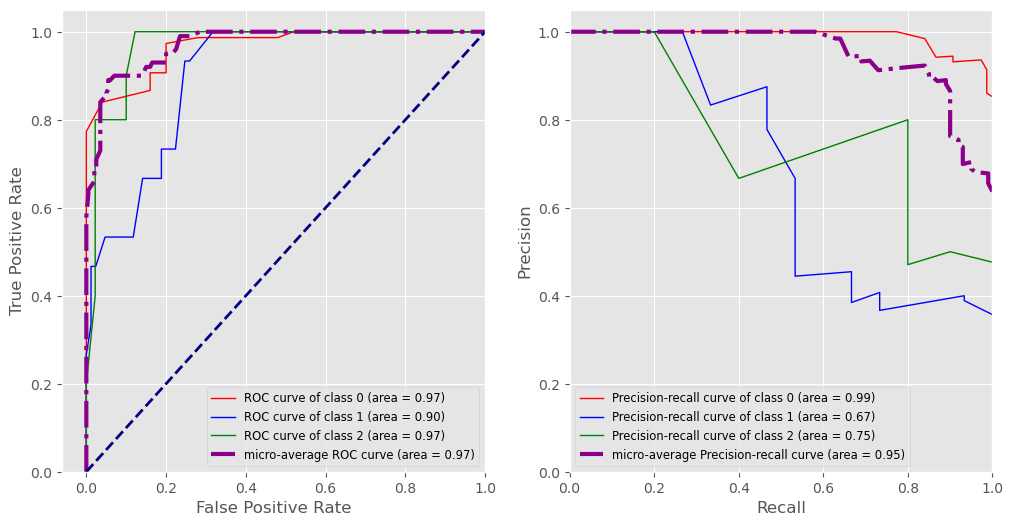

In [11]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [2, 4, 6, 8, 16, 32, 64], 'min_samples_split': [10, 30, 50, 100, 500, 700]}
gs_score = 'roc_auc'

clf_dtrb, y_pred_dtrb, y_score_dtrb = multiclass_classify(model, clf_dtrb, df_train, df_test, features_orignal, 'mcc_label', gs_params, gs_score, OvR=True, prob='P')
print(f'\nBest Parameters:\n{clf_dtrb}')

metrics_dtrb, prc_dtrb, roc_dtrb = multiclass_metrics(model, y_test, y_pred_dtrb, y_score_dtrb, print_out=True, plot_out=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters:
DecisionTreeClassifier(max_depth=8, min_samples_split=500, random_state=123)
**********************************************************************
Decision Tree A 

Confusion Matrix:
[[74  1  0]
 [ 6  9  0]
 [ 0  3  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.95        75
           1       0.69      0.60      0.64        15
           2       1.00      0.70      0.82        10

    accuracy                           0.90       100
   macro avg       0.87      0.76      0.81       100
weighted avg       0.90      0.90      0.89       100


Metrics:
                    Decision Tree A
Accuracy                   0.900000
weighted F1                0.904272
micro F1                   0.909091
weighted Precision         0.915385
micro Precision            0.918367
weighted Recall            0.900000
micro Recall               0.9000

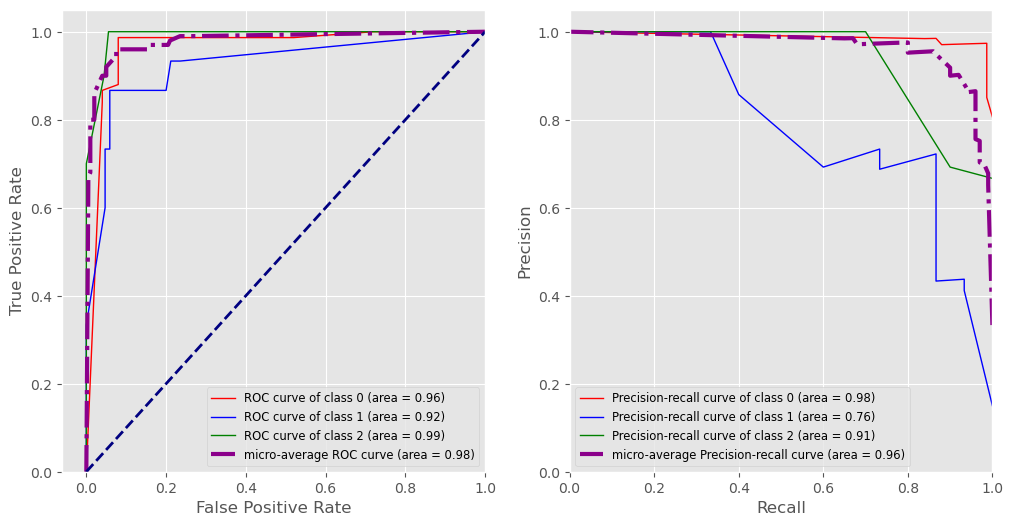

In [12]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [2, 4, 6, 8, 16, 32, 64], 'min_samples_split': [10, 30, 50, 100, 500, 700]}
gs_score = 'roc_auc'

clf_dtra, y_pred_dtra, y_score_dtra = multiclass_classify(model, clf_dtra, df_train, df_test, features_all, 'mcc_label', gs_params, gs_score, OvR=True, prob='P')
print(f'\nBest Parameters:\n{clf_dtrb}')

metrics_dtra, prc_dtra, roc_dtra = multiclass_metrics(model, y_test, y_pred_dtra, y_score_dtra, print_out=True, plot_out=True)


In [13]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

,Decision Tree B,Decision Tree A
Accuracy,0.850000,0.900000
weighted F1,0.841538,0.904272
micro F1,0.876289,0.909091
weighted Precision,0.915185,0.915385
micro Precision,0.904255,0.918367
weighted Recall,0.850000,0.900000
micro Recall,0.850000,0.900000
weighted ROC AUC,0.956519,0.961161
micro ROC AUC,0.970500,0.978700


## RandomForest

Fitting 5 folds for each of 10 candidates, totalling 50 fits



Best Parameters:
DecisionTreeClassifier(max_depth=8, min_samples_split=500, random_state=123)
**********************************************************************
Random Forest B 

Confusion Matrix:
[[75  0  0]
 [12  2  1]
 [ 4  0  6]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
           1       1.00      0.13      0.24        15
           2       0.86      0.60      0.71        10

    accuracy                           0.83       100
   macro avg       0.89      0.58      0.61       100
weighted avg       0.85      0.83      0.78       100


Metrics:
                    Random Forest B
Accuracy                   0.820000
weighted F1                0.812889
micro F1                   0.858639
weighted Precision         0.912544
micro Precision            0.901099
weighted Recall            0.820000
micro Recall               0.820000
weighted ROC AUC           0.973982
micro ROC AUC         

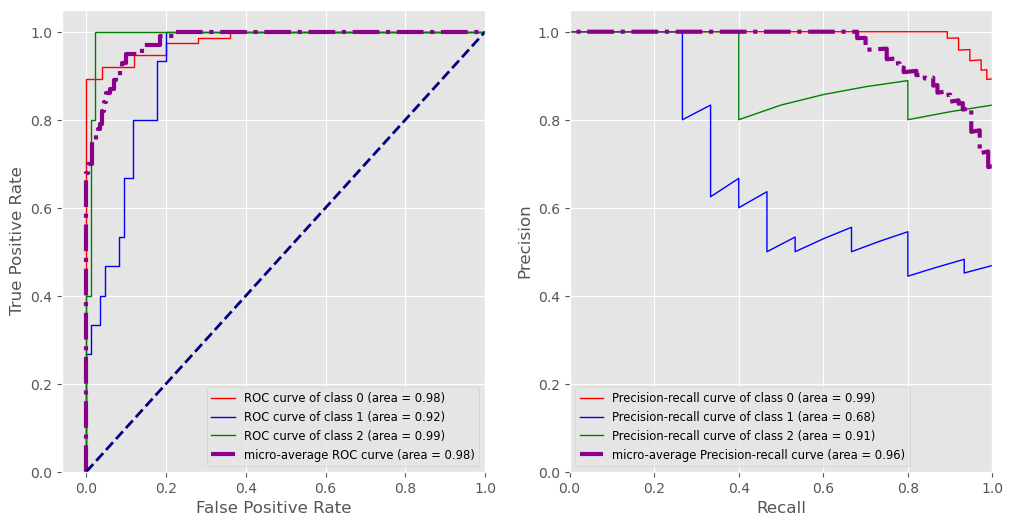

In [14]:
model = 'Random Forest B'
clf_rfb = RandomForestClassifier(random_state=123)
gs_params = {'max_depth': [2, 4, 6, 8, 16, 32, 64], 'min_samples_split': [10, 30, 50, 100, 500, 700], 'n_estimators': [10, 30, 50, 100, 500, 700]}
gs_score = 'roc_auc'

clf_rfb, y_pred_rfb, y_score_rfb = multiclass_classify(model, clf_rfb, df_train, df_test, features_orignal, 'mcc_label', gs_params, gs_score, OvR=True, prob='P')
print(f'\nBest Parameters:\n{clf_dtrb}')

metrics_rfb, prc_rfb, roc_rfb = multiclass_metrics(model, y_test, y_pred_rfb, y_score_rfb, print_out=True, plot_out=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters:
DecisionTreeClassifier(max_depth=8, min_samples_split=500, random_state=123)
**********************************************************************
Random Forest A 

Confusion Matrix:
[[74  1  0]
 [11  4  0]
 [ 0  2  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.57      0.27      0.36        15
           2       1.00      0.80      0.89        10

    accuracy                           0.86       100
   macro avg       0.81      0.68      0.73       100
weighted avg       0.84      0.86      0.84       100


Metrics:
                    Random Forest A
Accuracy                   0.860000
weighted F1                0.850441
micro F1                   0.873096
weighted Precision         0.862544
micro Precision            0.886598
weighted Recall            0.860000
micro Recall               0.8600

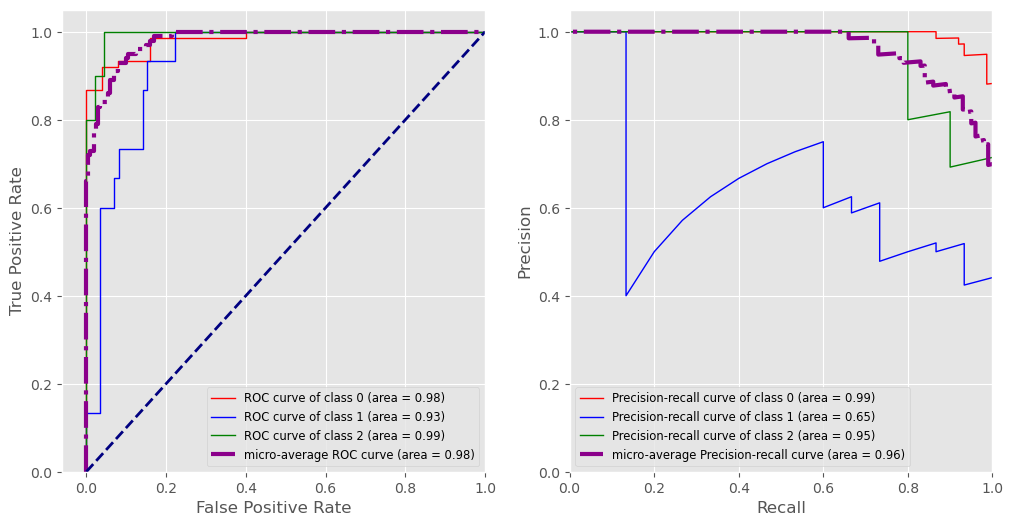

In [15]:
model = 'Random Forest A'
clf_rfa = RandomForestClassifier(random_state=123)
gs_params = {'max_depth': [2, 4, 6, 8, 16, 32, 64], 'min_samples_split': [10, 30, 50, 100, 500, 700], 'n_estimators': [10, 30, 50, 100, 500, 700]}
gs_score = 'roc_auc'

clf_rfa, y_pred_rfa, y_score_rfa = multiclass_classify(model, clf_rfa, df_train, df_test, features_all, 'mcc_label', gs_params, gs_score, OvR=True, prob='P')
print(f'\nBest Parameters:\n{clf_dtrb}')

metrics_rfa, prc_rfa, roc_rfa = multiclass_metrics(model, y_test, y_pred_rfa, y_score_rfa, print_out=True, plot_out=True)


In [16]:
metrics_rf = pd.concat([metrics_rfb, metrics_rfa], axis=1)
metrics_rf

,Random Forest B,Random Forest A
Accuracy,0.820000,0.860000
weighted F1,0.812889,0.850441
micro F1,0.858639,0.873096
weighted Precision,0.912544,0.862544
micro Precision,0.901099,0.886598
weighted Recall,0.820000,0.860000
micro Recall,0.820000,0.860000
weighted ROC AUC,0.973982,0.975945
micro ROC AUC,0.978850,0.980650


## KNeighborsClassifier

Fitting 5 folds for each of 10 candidates, totalling 50 fits



Best Parameters:
KNeighborsClassifier(n_neighbors=70)
**********************************************************************
KNN B 

Confusion Matrix:
[[75  0  0]
 [10  4  1]
 [ 1  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        75
           1       0.80      0.27      0.40        15
           2       0.89      0.80      0.84        10

    accuracy                           0.87       100
   macro avg       0.85      0.69      0.72       100
weighted avg       0.86      0.87      0.84       100


Metrics:
                       KNN B
Accuracy            0.850000
weighted F1         0.850662
micro F1            0.876289
weighted Precision  0.893264
micro Precision     0.904255
weighted Recall     0.850000
micro Recall        0.850000
weighted ROC AUC    0.976680
micro ROC AUC       0.980850


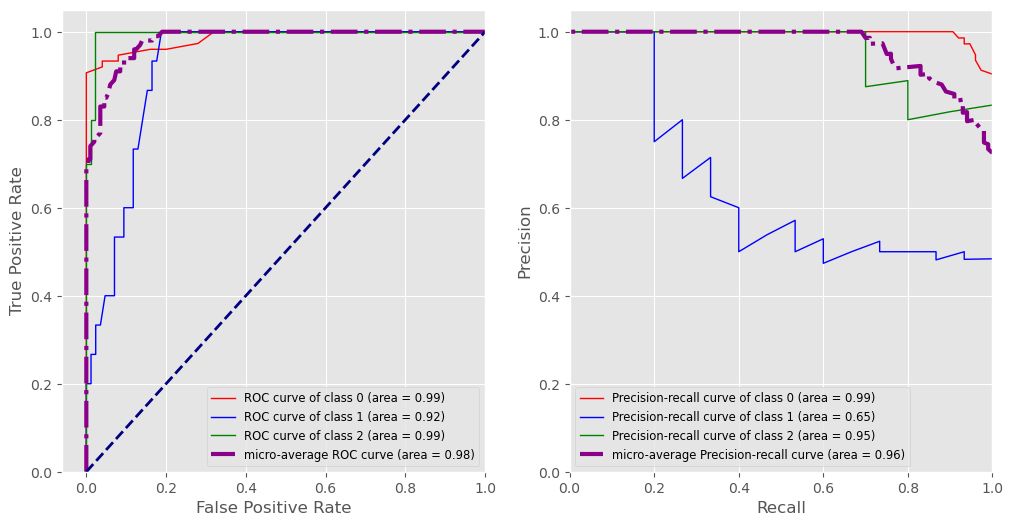

In [17]:
model = 'KNN B'
clf_knnb = KNeighborsClassifier()
gs_params = {'n_neighbors': [1, 2, 3, 4, 6, 8, 10, 16, 20, 30, 50, 70]}
gs_score = 'roc_auc'

clf_knnb, y_pred_knnb, y_score_knnb = multiclass_classify(model, clf_knnb, df_train, df_test, features_orignal, 'mcc_label', gs_params, gs_score, OvR=True, prob='P')
print(f'\nBest Parameters:\n{clf_knnb}')

metrics_knnb, prc_knnb, roc_knnb = multiclass_metrics(model, y_test, y_pred_knnb, y_score_knnb, print_out=True, plot_out=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters:
KNeighborsClassifier(n_neighbors=70)
**********************************************************************
KNN A 

Confusion Matrix:
[[74  1  0]
 [12  3  0]
 [ 2  1  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91        75
           1       0.60      0.20      0.30        15
           2       1.00      0.70      0.82        10

    accuracy                           0.84       100
   macro avg       0.81      0.63      0.68       100
weighted avg       0.82      0.84      0.81       100


Metrics:
                       KNN A
Accuracy            0.840000
weighted F1         0.834359
micro F1            0.865979
weighted Precision  0.866829
micro Precision     0.893617
weighted Recall     0.840000
micro Recall        0.840000
weighted ROC AUC    0.974506
micro ROC AUC       0.980050


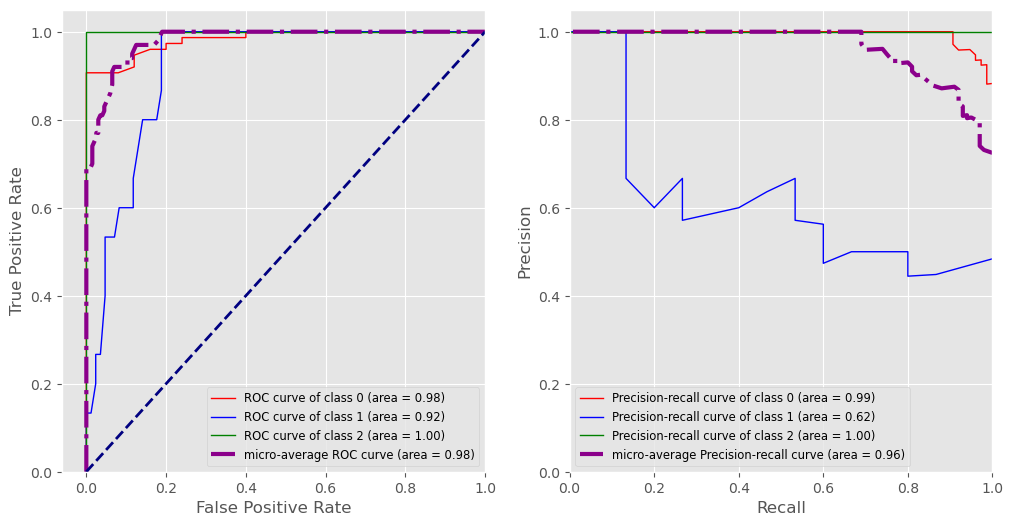

In [18]:
model = 'KNN A'
clf_knna = KNeighborsClassifier()
gs_params = {'n_neighbors': [1, 2, 3, 4, 6, 8, 10, 16, 20, 30, 50, 70]}
gs_score = 'roc_auc'

clf_knna, y_pred_knna, y_score_knna = multiclass_classify(model, clf_knna, df_train, df_test, features_all, 'mcc_label', gs_params, gs_score, OvR=True, prob='P')
print(f'\nBest Parameters:\n{clf_knna}')

metrics_knna, prc_knna, roc_knna = multiclass_metrics(model, y_test, y_pred_knna, y_score_knna, print_out=True, plot_out=True)


In [19]:
metrics_knn = pd.concat([metrics_knnb, metrics_knna], axis=1)
metrics_knn

,KNN B,KNN A
Accuracy,0.850000,0.840000
weighted F1,0.850662,0.834359
micro F1,0.876289,0.865979
weighted Precision,0.893264,0.866829
micro Precision,0.904255,0.893617
weighted Recall,0.850000,0.840000
micro Recall,0.850000,0.840000
weighted ROC AUC,0.976680,0.974506
micro ROC AUC,0.980850,0.980050


## LogisticRegression

Fitting 5 folds for each of 8 candidates, totalling 40 fits



Best Parameters:
OneVsRestClassifier(estimator=LogisticRegression(C=0.01, random_state=123,
                                                 solver='liblinear'))
**********************************************************************
Logistic Regression B 

Confusion Matrix:
[[75  0  0]
 [15  0  0]
 [ 3  0  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        75
           1       0.00      0.00      0.00        15
           2       1.00      0.70      0.82        10

    accuracy                           0.82       100
   macro avg       0.60      0.57      0.57       100
weighted avg       0.70      0.82      0.75       100


Metrics:
                    Logistic Regression B
Accuracy                         0.810000
weighted F1                      0.793891
micro F1                         0.861702
weighted Precision               0.785185
micro Precision                  0.920455
weighted Recall     

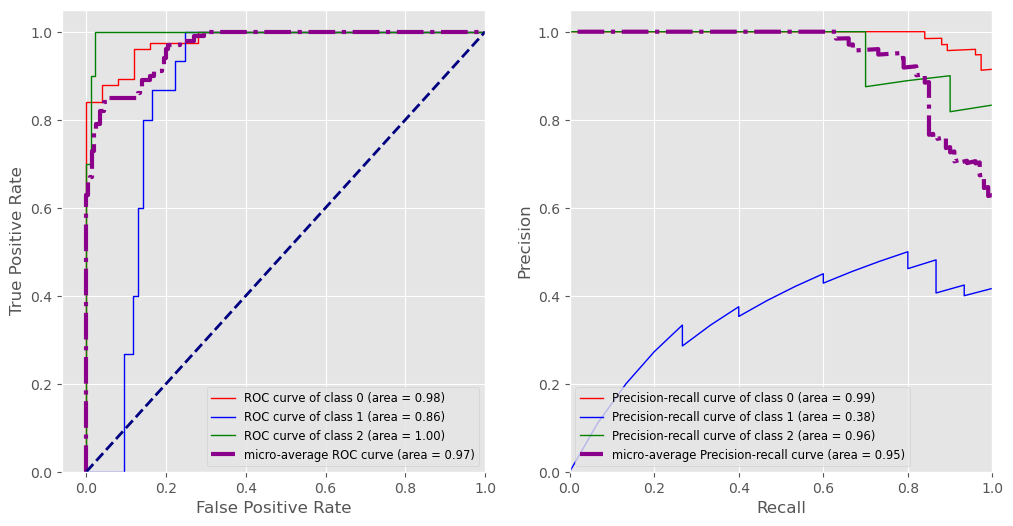

In [20]:
model = 'Logistic Regression B'
clf_lgrb = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgrb, y_pred_lgrb, y_score_lgrb = multiclass_classify(model, clf_lgrb, df_train, df_test, features_orignal, 'mcc_label', gs_params, gs_score, OvR=False, prob='P')
print(f'\nBest Parameters:\n{clf_lgrb}')

metrics_lgrb, prc_lgrb, roc_lgrb = multiclass_metrics(model, y_test, y_pred_lgrb, y_score_lgrb, print_out=True, plot_out=True)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters:
OneVsRestClassifier(estimator=LogisticRegression(C=0.01, random_state=123,
                                                 solver='liblinear'))
**********************************************************************
Logistic Regression A 

Confusion Matrix:
[[75  0  0]
 [15  0  0]
 [ 2  0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        75
           1       0.00      0.00      0.00        15
           2       1.00      0.80      0.89        10

    accuracy                           0.83       100
   macro avg       0.61      0.60      0.60       100
weighted avg       0.71      0.83      0.76       100


Metrics:
                    Logistic Regression A
Accuracy                         0.820000
weighted F1                      0.800427
micro F1                         0.867725
weighted Precision               0.785185
mi

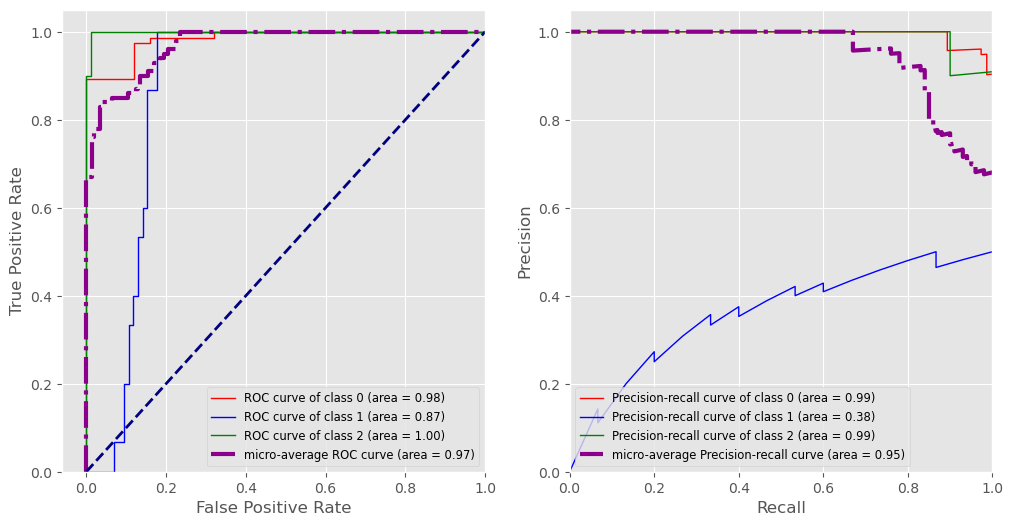

In [21]:
model = 'Logistic Regression A'
clf_lgra = OneVsRestClassifier(LogisticRegression(random_state=123))
gs_params = {'estimator__C': [.01, 0.1, 1.0, 10], 'estimator__solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'


clf_lgra, y_pred_lgra, y_score_lgra = multiclass_classify(model, clf_lgra, df_train, df_test, features_all, 'mcc_label', gs_params, gs_score, OvR=False, prob='P')
print(f'\nBest Parameters:\n{clf_lgra}')

metrics_lgra, prc_lgra, roc_lgra = multiclass_metrics(model, y_test, y_pred_lgra, y_score_lgra, print_out=True, plot_out=True)


In [22]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
Accuracy,0.810000,0.820000
weighted F1,0.793891,0.800427
micro F1,0.861702,0.867725
weighted Precision,0.785185,0.785185
micro Precision,0.920455,0.921348
weighted Recall,0.810000,0.820000
micro Recall,0.810000,0.820000
weighted ROC AUC,0.963767,0.968359
micro ROC AUC,0.966500,0.969150


## GaussianNB

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Parameters:
OneVsRestClassifier(estimator=GaussianNB())
**********************************************************************
GaussianNB B 

Confusion Matrix:
[[62 13  0]
 [ 0 15  0]
 [ 0 10  0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        75
           1       0.39      1.00      0.57        15
           2       0.00      0.00      0.00        10

    accuracy                           0.77       100
   macro avg       0.46      0.61      0.49       100
weighted avg       0.81      0.77      0.76       100


Metrics:
                    GaussianNB B
Accuracy                0.620000
weighted F1             0.816332
micro F1                0.763158
weighted Precision      0.844878
micro Precision         0.679688
weighted Recall         0.870000
micro Recall            0.870000
weighted ROC AUC        0.970624
micro ROC AUC           0.

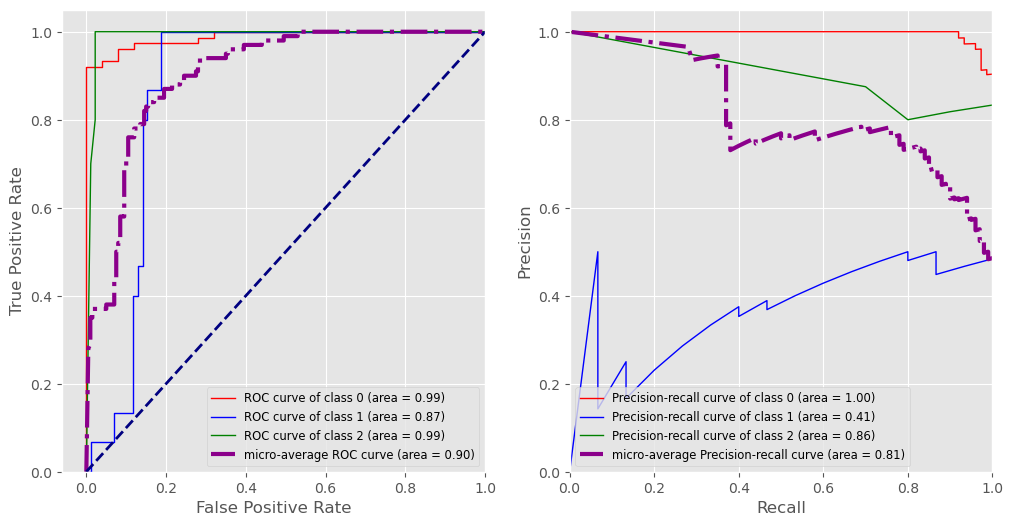

In [23]:
model = 'GaussianNB B'
clf_gnbb = OneVsRestClassifier(GaussianNB())
gs_params = {}
gs_score = 'roc_auc'


clf_gnbb, y_pred_gnbb, y_score_gnbb = multiclass_classify(model, clf_gnbb, df_train, df_test, features_orignal, 'mcc_label', gs_params, gs_score, OvR=False, prob='P')
print(f'\nBest Parameters:\n{clf_gnbb}')

metrics_gnbb, prc_gnbb, roc_gnbb = multiclass_metrics(model, y_test, y_pred_gnbb, y_score_gnbb, print_out=True, plot_out=True)


Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best Parameters:
OneVsRestClassifier(estimator=GaussianNB())
**********************************************************************
GaussianNB A 

Confusion Matrix:
[[62 13  0]
 [ 0 15  0]
 [ 0 10  0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        75
           1       0.39      1.00      0.57        15
           2       0.00      0.00      0.00        10

    accuracy                           0.77       100
   macro avg       0.46      0.61      0.49       100
weighted avg       0.81      0.77      0.76       100


Metrics:
                    GaussianNB A
Accuracy                0.600000
weighted F1             0.814438
micro F1                0.756522
weighted Precision      0.843478
micro Precision         0.669231
weighted Recall         0.870000
micro Recall            0.870000
weighted ROC AUC        0.966923
micro ROC AUC           0.

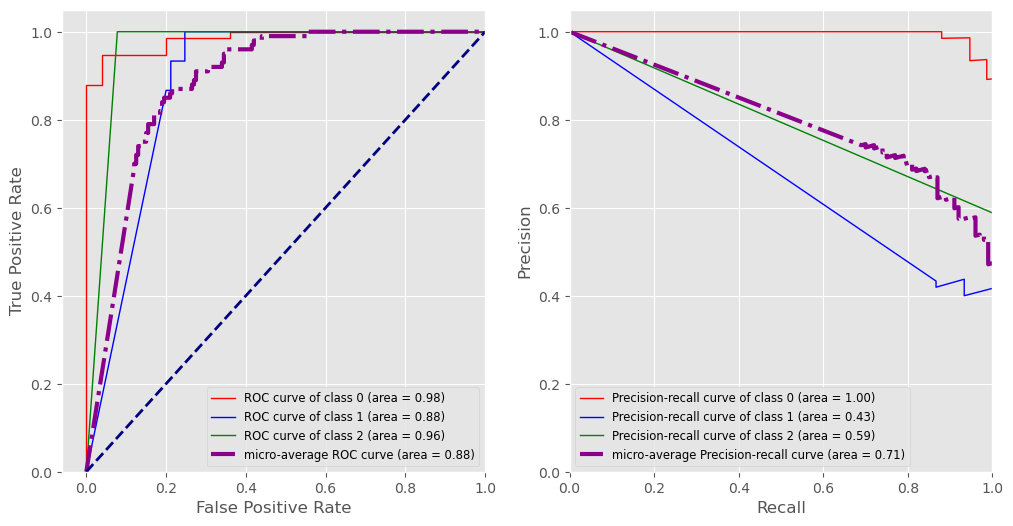

In [24]:
model = 'GaussianNB A'
clf_gnba = OneVsRestClassifier(GaussianNB())
gs_params = {}
gs_score = 'roc_auc'


clf_gnba, y_pred_gnba, y_score_gnba = multiclass_classify(model, clf_gnba, df_train, df_test, features_all, 'mcc_label', gs_params, gs_score, OvR=False, prob='P')
print(f'\nBest Parameters:\n{clf_gnba}')

metrics_gnba, prc_gnba, roc_gnba = multiclass_metrics(model, y_test, y_pred_gnba, y_score_gnba, print_out=True, plot_out=True)


In [25]:
metrics_gnb = pd.concat([metrics_gnbb, metrics_gnba], axis=1)
metrics_gnb

,GaussianNB B,GaussianNB A
Accuracy,0.620000,0.600000
weighted F1,0.816332,0.814438
micro F1,0.763158,0.756522
weighted Precision,0.844878,0.843478
micro Precision,0.679688,0.669231
weighted Recall,0.870000,0.870000
micro Recall,0.870000,0.870000
weighted ROC AUC,0.970624,0.966923
micro ROC AUC,0.904125,0.883550


## Deep Neural Network

In [7]:
# original features
features_orignal = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_all = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                's15', 's16', 's17', 's18', 's19', 's20', 's21', 'avg1', 'avg2', 'avg3','avg4', 'avg5', 'avg6', 'avg7', 'avg8', 'avg9', 'avg10',
                'avg11','avg12', 'avg13', 'avg14', 'avg15', 'avg16', 'avg17', 'avg18', 'avg19','avg20', 'avg21', 'std1', 'std2', 'std3', 'std4',
                'std5', 'std6','std7', 'std8', 'std9', 'std10', 'std11', 'std12', 'std13', 'std14','std15', 'std16', 'std17', 'std18', 'std19', 'std20', 'std21']

# get target
y_train = df_train['mcc_label']
y_test = df_test['mcc_label']

X_train, X_test = split_data(df_train, df_test, features_orignal, 'mcc_label')

y_train = tf.keras.utils.to_categorical(y_train, num_classes=3,dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3,dtype='float32')


In [ ]:
# set seed for reproducibility
tf.random.set_seed(1234)

# Define a list of layer architectures to try
layer_architectures = [

      [ Dense(units = 32, activation='relu', name = 'L1', input_shape=(24,)),
      Dense(units = 3, name = 'L11', activation='softmax')],

      [Dense(units = 65, activation='relu', name = 'L2222', input_shape=(24,)),
      Dense(units = 3, name = 'L22222', activation='softmax')],

      [Dense(units = 65, activation='relu', name = 'L999999', input_shape=(24,)),
      Dense(units = 32, activation='relu', name = 'L99999'),
      Dense(units = 3, name = 'L9999', activation='softmax')],

      [Dense(units = 65, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L2', input_shape=(24,)),
      Dense(units = 3, name = 'L22', activation='softmax')],

      [Dense(units = 65, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L9', input_shape=(24,)),
      Dense(units = 32, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1), name = 'L99'),
      Dense(units = 3, name = 'L999', activation='softmax')],

      [Dense(units = 125, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L3', input_shape=(24,)),
      Dense(units = 65, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L33'),
      Dense(units = 3, name = 'L333', activation='softmax')],

      [Dense(units = 125, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L5', input_shape=(24,)),
      Dense(units = 64, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L55'),
      Dense(units = 3, name = 'L555', activation='softmax')],



      [Dense(units = 300, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L8', input_shape=(24,)),
      Dense(units = 200, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L88'),
      Dense(units = 164, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L888'),
      Dense(units = 125, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L8888'),
      Dense(units = 64, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L88888'),
      Dense(units = 32, activation='relu',
            kernel_regularizer = tf.keras.regularizers.l2(0.1),
            name = 'L888888'),
      Dense(units = 3, name = 'L8888888', activation='softmax')],

      # Add more layer configurations as desired
]

best_model = None
best_accuracy = 0.0

# Loop over each layer architecture and train/evaluate the model
for architecture in layer_architectures:
      model = tf.keras.Sequential(architecture)

      # Compile the model
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

      # Fit the model
      model.fit(X_train, y_train, epochs=50, verbose=1)

      # Evaluate the model
      _, accuracy = model.evaluate(X_test, y_test, verbose=1)

      print(f"Architecture: {architecture}")
      print(f"Accuracy: {accuracy:.3f}")

      # Track the best model based on the highest accuracy
      if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

print(f'<-- best_accuracy: {best_accuracy}')

Epoch 1/50
645/645 [==============================] - 3s 3ms/step - loss: 0.1979 - accuracy: 0.9206
Epoch 2/50
645/645 [==============================] - 2s 3ms/step - loss: 0.1851 - accuracy: 0.9255
Epoch 3/50
645/645 [==============================] - 2s 4ms/step - loss: 0.1776 - accuracy: 0.9279
Epoch 4/50
645/645 [==============================] - 2s 4ms/step - loss: 0.1857 - accuracy: 0.9260
Epoch 5/50
645/645 [==============================] - 2s 3ms/step - loss: 0.1829 - accuracy: 0.9282
Epoch 6/50
645/645 [==============================] - 2s 3ms/step - loss: 0.1808 - accuracy: 0.9264
Epoch 7/50
645/645 [==============================] - 2s 3ms/step - loss: 0.1823 - accuracy: 0.9277
Epoch 8/50
645/645 [==============================] - 2s 3ms/step - loss: 0.1752 - accuracy: 0.9285
Epoch 9/50
645/645 [==============================] - 2s 3ms/step - loss: 0.1910 - accuracy: 0.9263
Epoch 10/50
645/645 [==============================] - 2s 4ms/step - loss: 0.1867 - accuracy: 0.9289

In [8]:
model = Sequential(
     [
          Dense(units = 32, activation='relu', name = 'L1', input_shape=(24,)),
          Dense(units = 3, name = 'L11', activation='softmax')
     ])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=50, verbose=1)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Accuracy: {accuracy:.3f}")


Epoch 1/50
645/645 [==============================] - 9s 13ms/step - loss: 0.1887 - accuracy: 0.9222
Epoch 2/50
645/645 [==============================] - 7s 10ms/step - loss: 0.1825 - accuracy: 0.9248
Epoch 3/50
645/645 [==============================] - 6s 10ms/step - loss: 0.1822 - accuracy: 0.9264
Epoch 4/50
645/645 [==============================] - 5s 8ms/step - loss: 0.1710 - accuracy: 0.9283
Epoch 5/50
645/645 [==============================] - 7s 11ms/step - loss: 0.1756 - accuracy: 0.9277
Epoch 6/50
645/645 [==============================] - 6s 9ms/step - loss: 0.1789 - accuracy: 0.9289
Epoch 7/50
645/645 [==============================] - 7s 12ms/step - loss: 0.1860 - accuracy: 0.9253
Epoch 8/50
645/645 [==============================] - 4s 7ms/step - loss: 0.2061 - accuracy: 0.9281
Epoch 9/50
645/645 [==============================] - 6s 9ms/step - loss: 0.1872 - accuracy: 0.9289
Epoch 10/50
645/645 [==============================] - 6s 9ms/step - loss: 0.1775 - accuracy: 0

# Compare all multiclass classification algorithms 

In [26]:
# compare all models
metrics_mc = pd.concat([metrics_lgr, metrics_dtr, metrics_rf, metrics_knn, metrics_gnb], axis=1).T
metrics_mc

,Accuracy,weighted F1,micro F1,weighted Precision,micro Precision,weighted Recall,micro Recall,weighted ROC AUC,micro ROC AUC
Logistic Regression B,0.81,0.793891,0.861702,0.785185,0.920455,0.81,0.81,0.963767,0.966500
Logistic Regression A,0.82,0.800427,0.867725,0.785185,0.921348,0.82,0.82,0.968359,0.969150
Decision Tree B,0.85,0.841538,0.876289,0.915185,0.904255,0.85,0.85,0.956519,0.970500
Decision Tree A,0.90,0.904272,0.909091,0.915385,0.918367,0.90,0.90,0.961161,0.978700
Random Forest B,0.82,0.812889,0.858639,0.912544,0.901099,0.82,0.82,0.973982,0.978850
Random Forest A,0.86,0.850441,0.873096,0.862544,0.886598,0.86,0.86,0.975945,0.980650
KNN B,0.85,0.850662,0.876289,0.893264,0.904255,0.85,0.85,0.976680,0.980850
KNN A,0.84,0.834359,0.865979,0.866829,0.893617,0.84,0.84,0.974506,0.980050
GaussianNB B,0.62,0.816332,0.763158,0.844878,0.679688,0.87,0.87,0.970624,0.904125
GaussianNB A,0.60,0.814438,0.756522,0.843478,0.669231,0.87,0.87,0.966923,0.883550


- As we see that **Random Forest A** and **KNN B** perform the best in terms of micro ROC AUC.
- KNN B outperforms Random Forest A in terms of precision and f1 but not in recall.
- KNN A outperforms rest of models in terms of micro ROC AUC.
- highest F1 score is achieved by Decision Tree A, and acually ROC AUC is not bad.

Text(0.5, 1.0, 'micro Precision Recall')

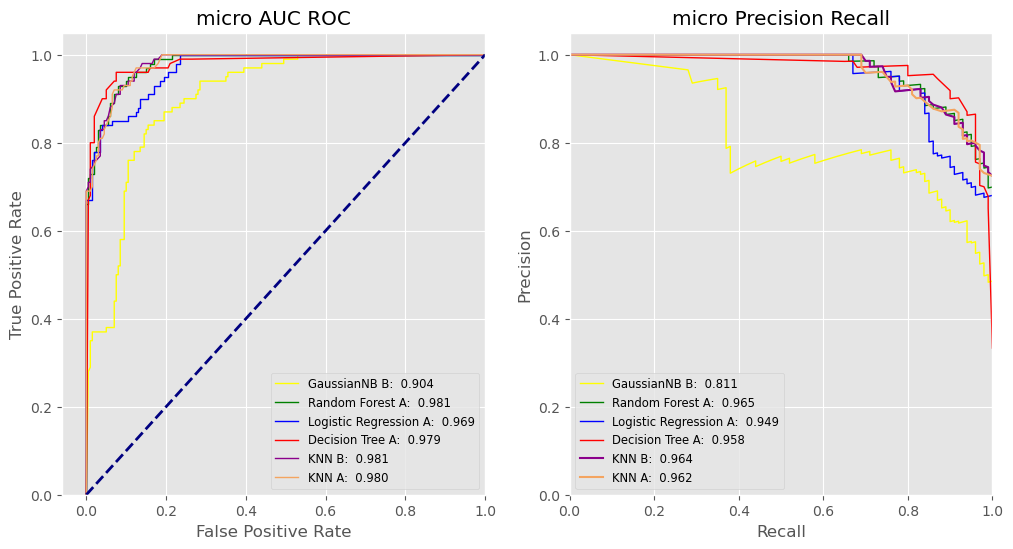

In [29]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(12,6)

ax1.plot(roc_gnbb.FPR['micro'], roc_gnbb.TPR['micro'], color='yellow', lw=1, label= roc_gnbb.Model['micro'] + ':  %.3f' % roc_gnbb.AUC['micro'])
ax1.plot(roc_rfa.FPR['micro'], roc_rfa.TPR['micro'], color='green', lw=1, label= roc_rfa.Model['micro'] + ':  %.3f' % roc_rfa.AUC['micro'])
ax1.plot(roc_lgra.FPR['micro'], roc_lgra.TPR['micro'], color='blue', lw=1, label= roc_lgra.Model['micro'] + ':  %.3f' % roc_lgra.AUC['micro'])
ax1.plot(roc_dtra.FPR['micro'], roc_dtra.TPR['micro'], color='red', lw=1, label= roc_dtra.Model['micro'] + ':  %.3f' % roc_dtra.AUC['micro'])
ax1.plot(roc_knnb.FPR['micro'], roc_knnb.TPR['micro'], color='darkmagenta', lw=1, label= roc_knnb.Model['micro'] + ':  %.3f' % roc_knnb.AUC['micro'])
ax1.plot(roc_knna.FPR['micro'], roc_knna.TPR['micro'], color='sandybrown', lw=1, label= roc_knna.Model['micro'] + ':  %.3f' % roc_knna.AUC['micro'])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.06, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('micro AUC ROC')

ax2.plot(prc_gnbb.Recall['micro'], prc_gnbb.Precision['micro'], color='yellow', lw=1, label= prc_gnbb.Model['micro'] + ':  %.3f' % prc_gnbb['Avg Precision']['micro'])
ax2.plot(prc_rfa.Recall['micro'], prc_rfa.Precision['micro'], color='green', lw=1, label= prc_rfa.Model['micro'] + ':  %.3f' % prc_rfa['Avg Precision']['micro'])
ax2.plot(prc_lgra.Recall['micro'], prc_lgra.Precision['micro'], color='blue', lw=1, label= prc_lgra.Model['micro'] + ':  %.3f' % prc_lgra['Avg Precision']['micro'])
ax2.plot(prc_dtra.Recall['micro'], prc_dtra.Precision['micro'], color='red', lw=1, label= prc_dtra.Model['micro'] + ':  %.3f' % prc_dtra['Avg Precision']['micro'])
ax2.plot(prc_knnb.Recall['micro'], prc_knnb.Precision['micro'], color='darkmagenta', label= prc_knnb.Model['micro'] + ':  %.3f' % prc_knnb['Avg Precision']['micro'])
ax2.plot(prc_knna.Recall['micro'], prc_knna.Precision['micro'], color='sandybrown', label= prc_knna.Model['micro'] + ':  %.3f' % prc_knna['Avg Precision']['micro'])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('micro Precision Recall')

**Multiclass Classification Summary:**

- **Random Forest A** outperforms all other models in the two graphs above.
- **Random Forest A** and **KNN B** perform the best in terms of micro ROC AUC.
- KNN B outperforms Random Forest A in terms of precision and f1 but not in recall.
- KNN A outperforms rest of models in terms of micro ROC AUC.
- highest F1 score is achieved by Decision Tree A, and acually ROC AUC is not bad.
